# Predicting Rocket Trajectory with Machine Learning 

Have you ever wondered if a machine learning model can predict the trajectory of a rocket given its specifications?

This notebook is structured in three parts:
- Part 1: We will compute the theoretical rocket trajectory equation
- Part 2: Then, we will explore how machine learning models can be used to compute rocket's maximum altitude reachable for a given fuel quantity and rocket's parameters
- Part 3: Finally, we will try to predict its altitude trajectory relative to time.  

But first, let's import all the libraries we'll need to build, train, and evaluate our models.


In [2]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, RidgeCV, Lasso, SGDRegressor, ElasticNet, MultiTaskElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor


## Reproducibility
seed = 42
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


### 1. Deriving rocket's trajectory equation

Predicting Rocket Trajectories with Machine Learning
In this notebook, we study the vertical trajectory of a simplified rocket model under the influence of thrust, gravity, and aerodynamic drag. The physical system is governed by Newton’s second law applied to a time-varying mass system:

$$
m(t) \cdot a(t) = \sum F
$$


where:
- $m(t)$ is the mass of the rocket, decreasing over time as fuel is consumed,
- $a(t)$ is the rocket's acceleration,
- $F$ are the forces applied on the rocket: thrust, gravity, and drag forces.

The net force acting on the rocket is:

$$
\sum F = T(t) - m(t)g - \frac{1}{2} \rho A C_D v(t)^2 
$$

with:
- $T(t)$: thrust force (constant while fuel remains),
- $g$: gravitational acceleration,
- $ρ$: air density,
- $C_D$: drag coefficient,
- $A$: cross-sectional area,
- $v(t)$: velocity of the rocket.

By integrating the acceleration over time using Euler’s method, we can simulate the evolution of altitude, velocity, and mass throughout the rocket’s flight.

Our goal in this notebook is to train a machine learning model to learn the mapping from initial rocket parameters (mass, fuel, thrust, drag, etc.) to the resulting trajectory—specifically, altitude as a function of time. This bypasses the need to numerically integrate the physical equations for each new configuration.

#### Example:
The simulation models a one-dimensional rocket launch. Given a set of physical parameters and initial conditions, we compute the altitude and velocity over time using simple numerical integration. We then generate a dataset of such trajectories and use it to train a model capable of predicting future trajectories directly from input parameters.

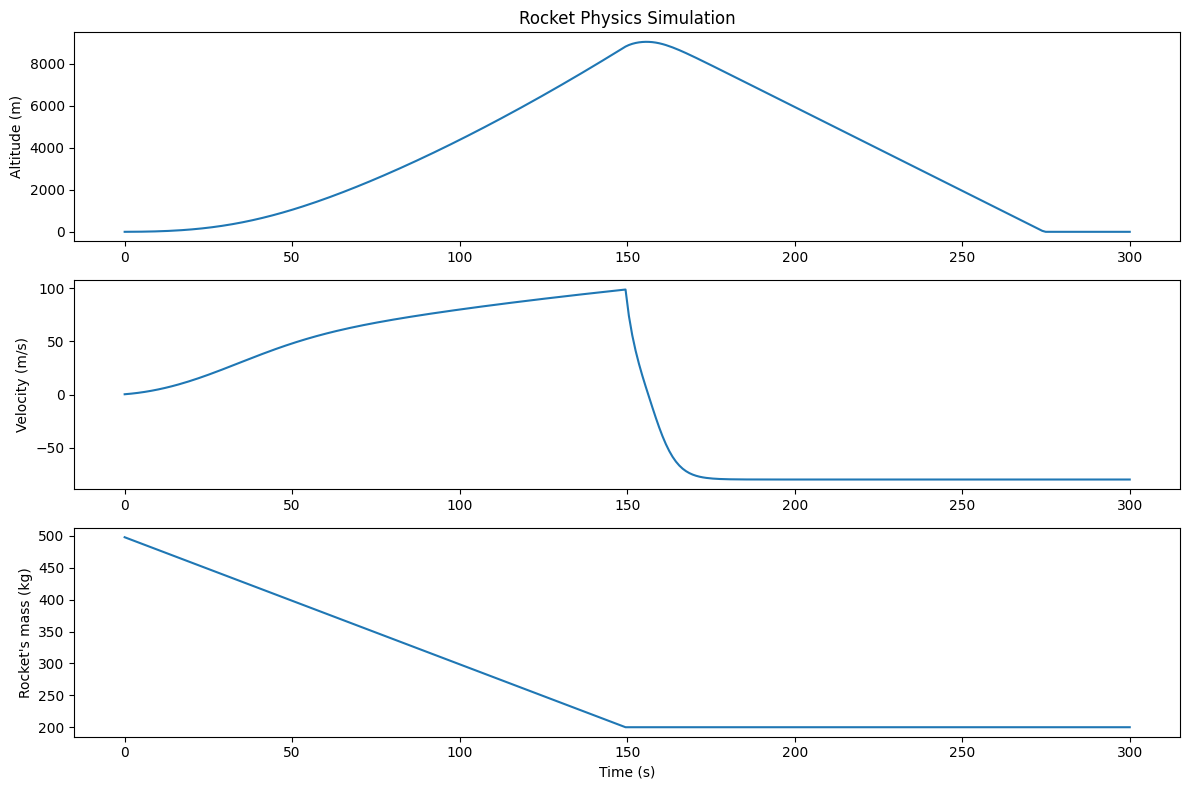

In [56]:
# Physical constants
G = 9.81  # gravity (m/s²)
AIR_DENSITY = 1.225  # air density at sea level (kg/m³)


# Rocket parameters
drag_coefficient = 0.5    # simplified drag coefficient
rocket_area = 1.0         # cross-sectional area (m²)
initial_mass = 500.0      # kg (total mass at liftoff)
fuel_mass = 300.0         # kg of fuel
burn_rate = 2.0           # kg/s (fuel consumption rate)
thrust = 5000.0           # N (constant thrust while fuel remains)




def rocket_simulation(rocket_area, initial_mass, fuel_mass, burn_rate, thrust, drag_coefficient):
    """ Simulates a 1D rocket launch and descent with constant thrust and drag. """

    # Initial conditions
    altitude = 0.1
    velocity = 0.0
    mass = initial_mass
    time = 0.0
    dt = 1  # time step (s)
    t_max = 300  # simulation duration (s)
    
    # State arrays
    altitudes = []
    velocities = []
    accelerations = []
    masses = []
    times = []

    # Simulation loop
    for time in np.linspace(0, t_max, int(t_max / dt)):
        
        # Update mass based on fuel consumption
        if fuel_mass > 0:
            dm = burn_rate * dt
            if dm > fuel_mass:
                dm = fuel_mass  # consume remaining fuel only
            fuel_mass -= dm
            mass -= dm
            current_thrust = thrust
        else:
            current_thrust = 0

        # Forces
        weight = mass * G
        drag = 0.5 * rocket_area * drag_coefficient * AIR_DENSITY * velocity**2 * np.sign(velocity)
        net_force = current_thrust - weight - drag
        acceleration = net_force / mass

        # Euler integration
        velocity += acceleration * dt
        altitude += velocity * dt

        # Store state
        times.append(time)
        altitudes.append(max(altitude, 0))
        velocities.append(velocity)
        accelerations.append(acceleration)
        masses.append(mass)
        
    return times, altitudes, velocities, masses


times, altitudes, velocities, masses = rocket_simulation(rocket_area, initial_mass, fuel_mass, burn_rate, thrust, drag_coefficient)

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(times, altitudes)
plt.ylabel("Altitude (m)")
plt.title("Rocket Physics Simulation")

plt.subplot(3, 1, 2)
plt.plot(times, velocities)
plt.ylabel("Velocity (m/s)")

plt.subplot(3, 1, 3)
plt.plot(times, masses)
plt.ylabel("Rocket's mass (kg)")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()


### 2. Predicting rocket's maximum altitude

In this first part, we want to predict the rocket's aximum altitude during its launch. To do so, we have to create a synthetic database containing the input rocket's parameters (6 values) and the output maximum altitude point (1 value). To create the dataset, we implemented the generate_dataset function that compute the output for 6 random input parameters.

Finally, we separate X and y dataset in a train and a test datasets and we train a model. We compute different metrics (like the R2 score) and we print random predictions.

In [1]:

def generate_random_params():
    rocket_area = np.random.uniform(0.5, 2.0)
    initial_mass = np.random.uniform(300, 800)
    fuel_mass = np.random.uniform(0.1, 0.7) * initial_mass 
    burn_rate = np.random.uniform(1, 10)
    thrust = 100 * fuel_mass
    drag_coefficient = np.random.uniform(0.1, 1.0)
    return [rocket_area, initial_mass, fuel_mass, burn_rate, thrust, drag_coefficient]


def generate_dataset(n):
    X = []
    y = []
    for _ in range(n):
        params = generate_random_params()
        _, altitudes, _, _ = rocket_simulation(*params)
        if np.isnan(altitudes).any():
            print("Simulation failed due to NaN altitude.")
            break
        X.append(params)
        y.append(max(altitudes))

    return np.array(X), np.array(y)


X, y = generate_dataset(n=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

model = make_pipeline(PolynomialFeatures(5), StandardScaler(), LinearRegression(n_jobs=-1))
model.fit(X_train, y_train)



# EVALUATION
score = model.score(X_test, y_test)
print(f"Model's R2 score : {score:.2f}")

y_predict = model.predict(X_test) 
print(f"Squared error (RMSE): {np.sqrt(mean_squared_error(y_test, y_predict)):.1f}")
print(f"Average difference (MAE): {mean_absolute_error(y_test, y_predict):.1f}\n")




# RANDOM PREDICTIONS
print(f"{'Index':<6} {'Real':>10} {'Predicted':>12} {'Difference':>12} {'Ratio':>8}")
print("-" * 52)

for i in np.random.choice(len(y_test), 5, replace=False):
    real = y_test[i]
    pred = y_predict[i]
    diff = abs(real - pred)
    ratio = diff / real
    print(f"{i:<6} {real:>10.1f} {pred:>12.1f} {diff:>12.1f} {ratio:>8.2%}")


NameError: name 'np' is not defined

### 3. Predicting rocket's altitude curve

#### Dataset creation

Now, we want to train a model able to generate the altitude curve given rocket's parameters. To do so, we have to create a synthetic database containing the input rocket's parameters (6 values) and the output altitude curve (a list of 300 points). To create the dataset, we implemented the generate_dataset function that creates all possible force vector with one non-zero value placed on one of the nodes.

Finally, we nomalize X and Y fields and we separate each dataset in a train and a test datasets.

In [58]:


def generate_random_params():
    rocket_area = np.random.uniform(0.5, 2.0)
    initial_mass = np.random.uniform(300, 800)
    fuel_mass = np.random.uniform(0.1, 0.7) * initial_mass 
    burn_rate = np.random.uniform(1, 10)
    thrust = 100 * fuel_mass
    drag_coefficient = np.random.uniform(0.1, 1.0)
    
    return [rocket_area, initial_mass, fuel_mass, burn_rate, thrust, drag_coefficient]



def generate_dataset(n):
    X = []
    Y = []
    for _ in range(n):
        params = generate_random_params()
        _, altitudes, _, _ = rocket_simulation(*params)
        if np.isnan(altitudes).any():
            print("Simulation failed due to NaN altitude.")
            break
        X.append(params)
        Y.append(altitudes)

    return np.array(X), np.array(Y)


X, Y = generate_dataset(n=10000)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

print("Training set size:", X_train.shape, Y_train.shape)
print("Test set size:", X_test.shape, Y_test.shape)




Training set size: (8000, 6) (8000, 300)
Test set size: (2000, 6) (2000, 300)


#### Model training

We are going to train different models to select the one which performs best. We use in this section two preprocessing functions:  
-PolynomialFeatures : Creates polynomial combinaisons of inputs : PolynomialFeatures([a, b], 2) = [1, a, b, a^2, ab, b^2]  
-StandardScaler : Shift the dataset to have a mean of 0 and a standard deviation of 1 for each variable.


When to use StandardScaler: 
Models computing distances, computing scalar products or making a gradient descent (sensitive to scale difference between variables):
- LinearRegression
- SGDRegressor
- LogisticRegression
- SVM
- KNeighborsRegressor
- MLPRegressor

When to not use StandardScaler:
Models using threshold, and not distances, are unsensitive to scale between variables:
- DecisionTreeRegressor	
- RandomForestRegressor	
- GradientBoosting 
- AdaBoost



Training time: 49.06s

Model's R2 score : 0.99
Model's RMSE: 1682.2



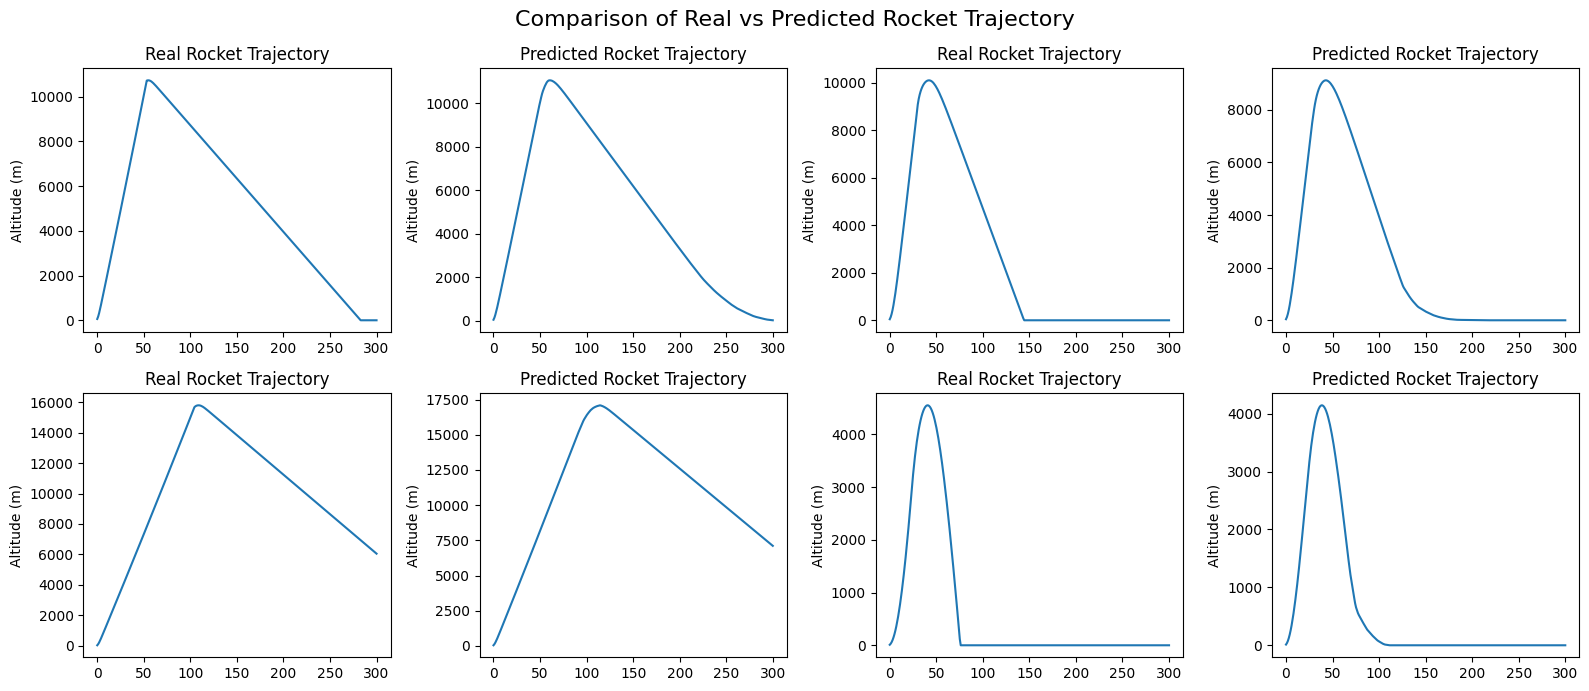

In [ ]:
# model = make_pipeline(PolynomialFeatures(5), StandardScaler(), LinearRegression(n_jobs=-1)) # 1707 
# model = make_pipeline(PolynomialFeatures(5), StandardScaler(), MultiOutputRegressor(SGDRegressor())) # 6e10
# model = make_pipeline(PolynomialFeatures(3), StandardScaler(), KNeighborsRegressor(n_neighbors=5)) # 12058
# model = make_pipeline(PolynomialFeatures(3), StandardScaler(), MultiOutputRegressor(SVR(kernel='rbf'))) # 14466
# model = make_pipeline(PolynomialFeatures(3), StandardScaler(), Ridge()) # 3273
# model = make_pipeline(PolynomialFeatures(3), StandardScaler(), Lasso()) # 3332 # 11462

# model = make_pipeline(PolynomialFeatures(3), DecisionTreeRegressor()) # 3109 
# model = make_pipeline(PolynomialFeatures(3), RandomForestRegressor()) # 2611
# model = make_pipeline(PolynomialFeatures(3), GaussianProcessRegressor()) # 15184
# model = make_pipeline(PolynomialFeatures(3), MultiOutputRegressor(GradientBoostingRegressor(n_estimators=50))) # (too long)
# model = make_pipeline(XGBRegressor(n_estimators=100)) # 1606 (1min) (too long with PolynomialFeatures)

model = make_pipeline(PolynomialFeatures(3), ExtraTreesRegressor(n_estimators=100, n_jobs=-1)) # 1029 (best model)




start = time.perf_counter()
model.fit(X_train, Y_train)
end = time.perf_counter()
exe_time = end - start          
print(f"Training time: {exe_time:.2f}s\n") 




## EVALUATION
score = model.score(X_test, Y_test)
print(f"Model's R2 score : {score:.2f}")

Y_predict = model.predict(X_test) 
print(f"Model's RMSE: {np.sqrt(mean_squared_error(Y_test, Y_predict)):.1f}\n")



## PLOT RANDOM PREDICTIONS
fig, ax = plt.subplots(2, 4, figsize=(16, 7))
fig.suptitle("Comparison of Real vs Predicted Rocket Trajectory", fontsize=16)

for idx, i in enumerate([31, 47, 122, 180]):
    plt.subplot(241 + 2*idx)
    plt.plot(times, Y_test[i])
    plt.ylabel("Altitude (m)")
    plt.title("Real Rocket Trajectory")

    plt.subplot(242 + 2*idx)
    plt.plot(times, Y_predict[i])
    plt.ylabel("Altitude (m)")
    plt.title("Predicted Rocket Trajectory")

plt.tight_layout()
plt.show()


### Inference time

One interesting result is that the inference time of the model is faster than the differential equation Euler resolution. This can be useful in real world applications, like in the space industry.

In [ ]:
import timeit

model = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))
model.fit(X_train, Y_train)

params = generate_random_params()
array = np.array(params).reshape(1, -1)

exe_time_spa = np.array(timeit.repeat('rocket_simulation(*params)', globals=globals(), number=500)) / 1e2
exe_time_mod = np.array(timeit.repeat('model.predict(array)', globals=globals(), number=500)) / 1e2

print(f"Euler resolution execution time : {(np.mean(exe_time_spa)/1e-3):.3f} ms, variance : {(np.var(exe_time_spa)/1e-9):.2f} ns")
print(f"ML model execution time         : {(np.mean(exe_time_mod)/1e-3):.3f} ms, variance : {(np.var(exe_time_mod)/1e-9):.2f} ns")

Euler resolution execution time : 3.216 ms, variance : 20.96 ns
ML model execution time         : 1.710 ms, variance : 4.13 ns


### Balistique prédiction distance d’arrivée